In [5]:
%matplotlib inline
%load_ext autoreload

In [6]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../../mbspbs10pc')

from mbspbs10pc import utils

# Check MBS-PBS 10% data availability

In [ ]:
ROOT = os.path.join('..','..','..','data')

mbs_files = filter(lambda x: x.startswith('MBS'), os.listdir(ROOT))
pbs_files = filter(lambda x: x.startswith('PBS'), os.listdir(ROOT))
sample_pin_lookout = filter(lambda x: x.startswith('SAMPLE'), os.listdir(ROOT))[0]

print('MBS files:')
for mbs in mbs_files:
    print('{}'.format(os.path.join(ROOT, mbs)))
    
print('PBS files:')
for pbs in pbs_files:
    print('{}'.format(os.path.join(ROOT, pbs)))
    
print('Sample PIN lookout: {}'.format(os.path.join(ROOT, sample_pin_lookout)))

# PBS take a look

In [ ]:
filename = pbs_files[0]
df = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), header=0, index_col=0, nrows=1000)
df.shape

In [ ]:
df.head()

In [ ]:
dd = pd.read_csv(os.path.join('..', 'data', 'drugs_used_in_diabetes.csv'), header=0)

# Fix 6-digit notation
dd_set = set()
for item in dd.values.ravel():
    if len(item)<6:
        dd_set.add(str(0)+item)
    else:
        dd_set.add(item)

In [ ]:
print(dd_set)

In [ ]:
for filename in pbs_files:
    reader = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), chunksize=1000)
    
    for i, chunk in enumerate(reader):
        idx = chunk.loc[chunk['ITM_CD'].isin(dd_set)]['ITM_CD'].index
        if len(idx)> 0: print(idx)
    break

In [ ]:
import multiprocessing as mp
from multiprocessing import Manager

manager = Manager()
results = manager.dict()

def process_chunk(i, chunk, results):
    # process data frame
    idx = chunk.loc[chunk['ITM_CD'].isin(dd_set)]['PTNT_ID']
    if len(idx)>0: results[i] = idx.values

reader = pd.read_csv(os.path.join(ROOT, '{}'.format(filename)), chunksize=5000)
pool = mp.Pool(8) # use 4 processes

jobs = []
for i, chunk in enumerate(reader):
    # process each data frame
    f = pool.apply_async(process_chunk, [i, chunk, results])
    jobs.append(f)

for f in jobs:
    f.get()

In [ ]:
pbs_years = [s.split('_')[-1].split('.')[0] for s in pbs_files]

In [74]:
import cPickle as pkl

with open('../tmp/df.pkl','rb') as f:
    dfy = pkl.load(f)

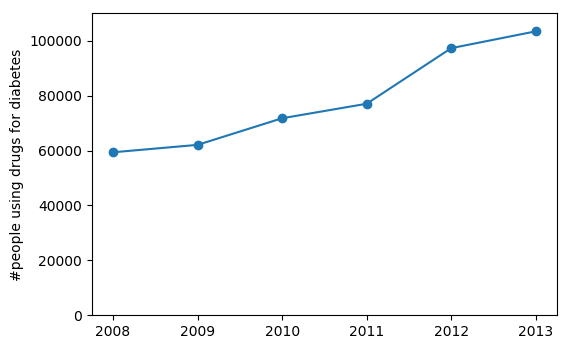

In [96]:
plt.figure(dpi=100)
lengths = [len(dfy['PBS_SAMPLE_10PCT_'+str(k)+'.csv']) for k in np.arange(2008,2014)]
plt.plot(np.arange(2008,2014), lengths, '-o')
plt.ylabel('#people using drugs for diabetes')
plt.ylim([0, 110000])
plt.savefig('../tmp/people_using_dd.png');

In [99]:
starting = []
for target_year in np.arange(2009, 2014):
    # From the target year, go backward and find the subjects
    # that were prescribed with diabete control drugs for the
    # first time
    positive_subjects = set(dfy['PBS_SAMPLE_10PCT_'+str(target_year)+'.csv'])

    for year in np.arange(2008, target_year)[::-1]:
        curr = set(dfy['PBS_SAMPLE_10PCT_'+str(year)+'.csv'])
        positive_subjects = set(filter(lambda x: x not in curr, positive_subjects))
    starting.append(len(positive_subjects))

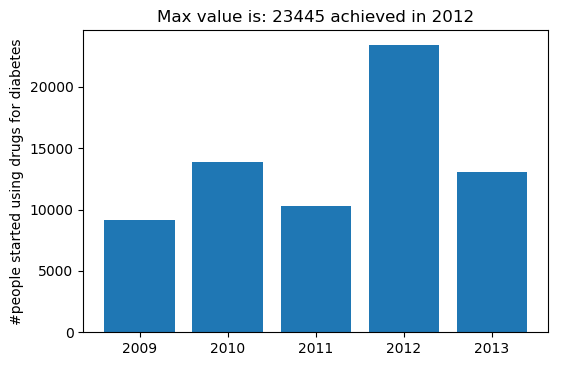

In [109]:
plt.figure(dpi=100)
plt.bar(np.arange(len(starting)), starting)
plt.xticks(np.arange(len(starting)), np.arange(2009, 2014))
plt.ylabel('#people started using drugs for diabetes')
plt.title('Max value is: {} achieved in {}'.format(np.max(starting),
                                             np.arange(2009, 2014)[np.argmax(starting)]))
plt.savefig('../tmp/people_started_using_dd.png');